In [1]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt 
import root_numpy
import pandas as pd
import numpy
#import seaborn
%matplotlib inline
#%matplotlib notebook
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.2 is currently installed but you installed root_numpy against numpy 1.11.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
def read_data(name, sub_folder, variables, treename="cbmsim"):
    return root_numpy.root2array(name, 
                                 treename=treename, 
                                 branches=[sub_folder + "." + branch for branch in variables])

In [3]:
#ecal_coords = read_data("ship.conical.PG-TGeant4_electron.root", "EcalPoint", ["EcalPont.fX", "EcalPoint.fY"])

In [4]:
# df = pd.DataFrame(columns = ['X', 'Y'])
# for index, event in enumerate(ecal_coords):
#     df.loc[index]= event

In [5]:
# X_list = []
# for value in df['X'].values:
#     X_list.extend(value[0])

In [21]:
filename = "5000_ele_ship.conical.PG-TGeant4_rec.root"
#filename = "ship.conical.PG-TGeant4_rec_muon.root"

In [22]:
%%time
true_tracks = read_data(filename, "MCTrack",
                        ["MCTrack.fStartX", "MCTrack.fStartY", "MCTrack.fStartZ"])

CPU times: user 386 ms, sys: 21.3 ms, total: 407 ms
Wall time: 446 ms


In [23]:
ecal_coords = read_data(filename, "EcalPointLite",
                        ["fDetectorID", "fELoss", 'fTrackID'])

In [24]:
ecal_coords_point = read_data(filename, "EcalPoint",
                        ["EcalPoint.fX", "EcalPoint.fY", 'fTime','fTrackID'])

## convert to cells

In [25]:
# Int_t volid=fVolID;
#   Int_t cell=volid%100-1;
#     volid=volid-cell-1;
#     volid/=100;
    
    
#   Int_t mx=volid%100;
#     volid-=mx;
#     volid/=100;
    
#   Int_t my=volid%100; 
#     volid-=my;
#     volid/=100;
    
    
#   Int_t type=inf->GetType(mx, my);
#   Int_t cx=cell%type;
#   Int_t cy=cell/type;

In [26]:
def get_position(detector_id, cell_type=2):
    cell = detector_id % 100 - 1
    cell_column = cell % cell_type
    cell_row = cell // cell_type

    detector_id -= (cell + 1)
    detector_id //= 100

    module_column = detector_id % 100
    detector_id -= module_column
    detector_id //= 100

    module_row = detector_id % 100
    detector_id -= module_row
    detector_id //= 100
    return ((module_column, module_row), (cell_column, cell_row))

In [27]:
# def get_picture(event, cell_type=2):
#     hits_position = [get_position(id) for id in event[0]]
    
#     min_col = min(hits_position, key=lambda x: x[0][0])[0][0]
#     min_row = min(hits_position, key=lambda x: x[0][1])[0][1]
    
#     max_col = max(hits_position, key=lambda x: x[0][0])[0][0]
#     max_row = max(hits_position, key=lambda x: x[0][1])[0][1]
#     print(min_col, max_col, min_row, max_row)
    
#     #hits_picture = np.zeros(((max_row - min_row + 1) * cell_type, (max_col - min_col + 1) * cell_type))
    
#     hits_picture = np.zeros((100, 100))
    
#     for coords, energy in zip(hits_position, event[1]):
#         hits_picture[(coords[0][1] - min_row) * cell_type + coords[1][1],
#                      (coords[0][0] - min_col) * cell_type + coords[1][0]] += energy

#     hits_picture /= hits_picture.max()
    
    
#     max_row, max_col = np.where(hits_picture == 1)
#     print(max_row, max_col)
#     return hits_picture[max_row[0] - 3 : max_row[0] + 3, max_col[0] - 3 : max_col[0] + 3]

In [28]:
def get_picture(event, cell_type=2, offset=100):
    hits_position = [get_position(id) for id in event[0]]
    
    min_col = min(hits_position, key=lambda x: x[0][0])[0][0]
    min_row = min(hits_position, key=lambda x: x[0][1])[0][1]
    
    max_col = max(hits_position, key=lambda x: x[0][0])[0][0]
    max_row = max(hits_position, key=lambda x: x[0][1])[0][1]
    #print(min_row, max_row, min_col, max_col)
    #print(max(hits_position, key=lambda x: x[0][1]))
    #hits_picture = np.zeros(((max_row - min_row + 1) * cell_type, (max_col - min_col + 1) * cell_type))
    
    hits_picture = np.zeros((offset * 3, offset * 3))
    
    for coords, energy in zip(hits_position, event[1]):
        hits_picture[(coords[0][1]) * cell_type + coords[1][1] + offset,
                     (coords[0][0]) * cell_type + coords[1][0] + offset] += energy

    #hits_picture /= hits_picture.max()
    
    max_val = hits_picture.max()
    max_row, max_col = np.where(hits_picture == max_val)
    #print(max_row, max_col)
    #return hits_picture
    return hits_picture[max_row[0] - 10 : max_row[0] + 10, max_col[0] - 10 : max_col[0] + 10]

In [29]:
def find_max_coords(event, cell_type=2):
    hits_position = [get_position(id) for id in event[0]]
    
    min_col = min(hits_position, key=lambda x: x[0][0])[0][0]
    min_row = min(hits_position, key=lambda x: x[0][1])[0][1]
    
    max_col = max(hits_position, key=lambda x: x[0][0])[0][0]
    max_row = max(hits_position, key=lambda x: x[0][1])[0][1]
    
    return max_col - min_col, max_row - min_row

In [30]:
column_diff, row_diff = [], []
for event in ecal_coords:
    filter_ind = event[2] > 0    
    if len(event[0][filter_ind]) > 0:
        diff_col, diff_row = find_max_coords([event[0][filter_ind]])
        column_diff.append(diff_col)
        row_diff.append(diff_row)

In [31]:
len(row_diff)

4955

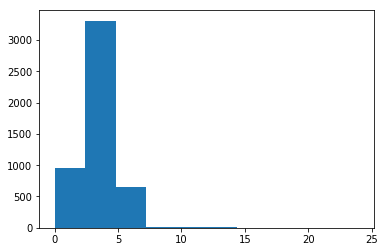

In [32]:
plt.hist(column_diff);

In [33]:
(np.array(row_diff) > 8).sum()

40

In [34]:
(np.array(column_diff) > 8).sum()

23

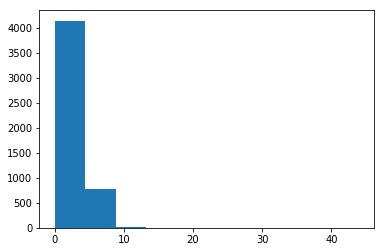

In [35]:
plt.hist(row_diff);

In [43]:
max([find_max_coords(event) for event in ecal_coords], key=lambda x: x[0])
max([(index, find_max_coords(event)) for index, event in enumerate(ecal_coords)], key=lambda x: x[1][1])

(176, (7, 26))

In [66]:
event_detector[0].shape

(82,)

In [163]:
print("X:", 12 * (21 - 22))
print("Y:", 12 * (39 - 48) + 60)

X: -12
Y: -48


In [178]:
index = 1

In [179]:
print(true_tracks[index][0])
print(true_tracks[index][1])

[ 0.          0.01811624 -0.03666231 -0.04171884 -0.04248096  0.08033624
 -0.04248096  0.42292842 -0.00522988  0.31972    -0.0403336   0.0401986
 -0.03356046  0.13481428  0.13481428  0.13490736  0.15004736  0.13923356
  0.0401986   0.04033255  0.04885241]
[  0.         -61.83911896 -61.53942871 -61.2924118  -61.42115402
 -63.00620651 -61.42115402 -63.36368942 -61.87334824 -63.44326019
 -61.55535507 -63.18338776 -61.64765167 -63.44700623 -63.44700623
 -63.4480896  -63.47952652 -63.51860428 -63.18338776 -63.18550491
 -63.31452942]


In [180]:
print(ecal_coords_point[index][0])
print(ecal_coords_point[index][1])
print(ecal_coords_point[index][2])
print(ecal_coords_point[index][3])

[ 3.08127880e-01  4.60853487e-01  2.76529759e-01  2.00022891e-01
  1.36494160e-01  1.11421756e-01  7.31690675e-02 -6.59275427e-02
 -1.00800457e+01  5.42800665e-01  4.10597712e-01  1.12475790e-01
  2.81931311e-01  2.24732980e-01  6.42723665e-02  3.82922068e-02
  1.07251845e-01 -6.58131485e+01]
[-63.46014023 -63.3750267  -63.07549667 -63.04738235 -62.93029022
 -62.90290451 -62.91635513 -63.01893234 -22.72583199 -63.86608505
 -63.05083084 -63.02993774 -63.26069641 -63.18275452 -63.12763596
 -63.14484787 -63.15245819  31.08253479]
[123.37902832 123.37880707 123.37752533 123.37738037 123.37699127
 123.37689972 123.37693024 123.37722778 123.45582581 123.38140869
 123.37759399 123.37729645 123.37817383 123.37785339 123.37759399
 123.3776474  123.37769318 127.52762604]
[ 0  1 -2 -2 -2 -2  2 -2 -2  4  6 -2  8 -2 -2 10 12 -2]


In [181]:
ecal_coords[index][2]

array([ 0,  0,  0,  0,  1,  1,  1,  1, -2, -2, -2,  2, -2,  4,  2, -2,  2,
       -2, -2,  1,  6,  6,  6,  6,  6,  6,  8,  8,  8,  8, -2, -2, 10, 10,
       10, 10, -2,  2,  4,  4,  4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10,
       10, 10, 10,  8,  6,  6,  2,  2,  6,  6,  0,  6], dtype=int32)

In [162]:
print(max(ecal_coords[index][0]))
ecal_coords[index][0]

392102


array([372203, 372104, 371904, 372102, 372201, 382201, 362103, 372101,
       382102, 372103, 372203, 372104, 372102, 372203, 372102, 372203,
       372203, 372201, 372104, 372102, 372203, 372203, 372203, 372203,
       372104, 372201, 372104, 372203, 372203, 372203, 372104, 372201,
       362104, 372104, 372102, 372201, 372203, 372201, 372102, 362203,
       362201, 362104, 372203, 372104, 372201, 382202, 372104, 372102,
       362104, 372201, 362103, 372204, 372202, 372203, 362103, 372102,
       372102, 372104, 372201, 382104, 382201, 372104, 372104, 362203,
       372202, 362303, 372102, 372201, 372101, 371902, 362004, 362203,
       372003, 382002, 362204, 382101, 362304, 392102, 382203, 362104,
       372204, 362301], dtype=int32)

In [175]:
bad_event_ind = []
for index, coords in enumerate(ecal_coords_point):
    if len(coords[2]) > 1:
        if np.max(np.abs(np.diff(coords[2]))) > 2:
            bad_event_ind.append(index)

In [176]:
bad_event_ind

[1, 7, 129, 156, 176, 196, 249, 382, 436, 460, 472, 476, 491]

In [177]:
ecal_coords_point[436][2]

array([123.42166901, 123.42003632, 123.42408752, 123.41804504,
       123.42194366, 123.41989136, 123.420578  , 123.42147827,
       123.42136383, 123.42156219, 123.44567108, 123.42393494,
       133.29646301])

In [124]:
get_position(372203)

((22, 37), (0, 1))

In [36]:
response = get_picture(ecal_coords[10])

In [37]:
np.unique(response)

array([0.00000000e+00, 1.42876641e-04, 2.48011493e-04, 2.56285741e-04,
       3.18950333e-04, 3.55660071e-04, 5.90928961e-04, 6.63591665e-04,
       7.10258842e-04, 7.42029864e-04, 9.17699595e-04, 9.81971643e-04,
       1.04728690e-03, 1.09443418e-03, 1.12760800e-03, 1.16762274e-03,
       1.19482091e-03, 1.52357328e-03, 1.57186888e-03, 1.71247666e-03,
       1.72594338e-03, 2.43665976e-03, 2.48597909e-03, 2.58640700e-03,
       3.31326219e-03, 5.95386699e-03, 6.69333537e-03, 9.27670272e-03,
       9.76916401e-03, 1.30811349e-02, 2.22865288e-02, 3.99976959e-02,
       6.73732200e-02, 9.61790545e-02, 1.19610662e+00])

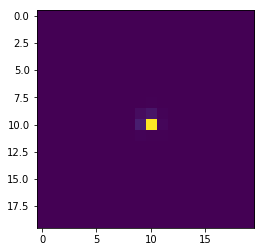

In [38]:
#print(e_energy[100])
plt.imshow(response)

## Get matrix of pictures

In [39]:
response_pictures = np.zeros((len(ecal_coords), 20, 20))
for index, event in enumerate(ecal_coords):
    if not index % 1000:
        print(index)
    response_pictures[index] = get_picture(event)

0
1000
2000
3000
4000


## Get electron true energy

In [40]:
import math

In [41]:
true_e_momentum = read_data(filename,"MCTrack",
                             ["MCTrack.fPx", "MCTrack.fPy", "MCTrack.fPz", "MCTrack.fM"])

In [42]:
e_energy = []
for electron in true_e_momentum:
    energy = math.sqrt(sum([val[0]**2 for val in electron]))
    e_energy.append(energy)
e_energy = np.array(e_energy)

In [43]:
e_loss_lite = []
for e_loss in ecal_coords:
    e_loss_lite.append(np.sum(e_loss[1]))
e_loss_lite = np.array(e_loss_lite)


e_loss_lite_new = []
for e_loss in response_pictures:
    e_loss_lite_new.append(np.sum(e_loss))
e_loss_lite_new = np.array(e_loss_lite_new)

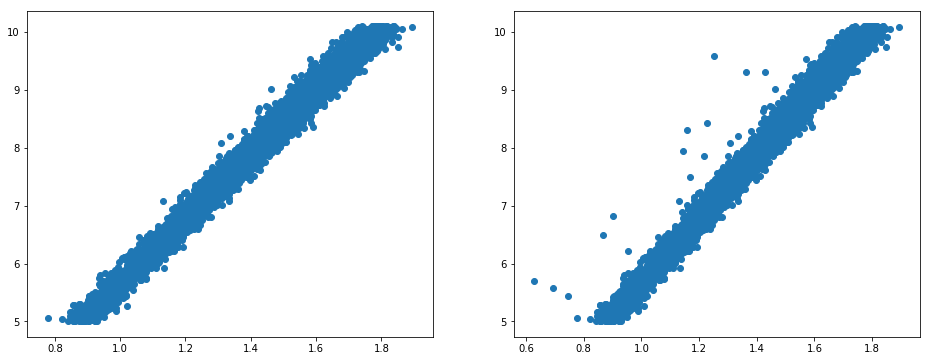

In [44]:
f, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].scatter(e_loss_lite, e_energy)
axes[1].scatter(e_loss_lite_new, e_energy)
#plt.scatter(e_loss_lite, e_energy)
#plt.xlim(1, 1.1)

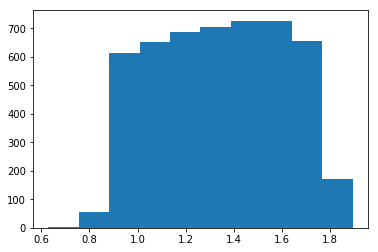

In [212]:
plt.hist(e_loss_lite);

## ML

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
#X_train, X_test, y_train, y_test = train_test_split(response_pictures, e_energy)
train_ind, test_ind = train_test_split(np.array(range(len(response_pictures))), test_size=0.1)

In [48]:
# X_train, X_test, y_train, y_test = response_pictures[train_ind], response_pictures[test_ind],\
#                                    e_energy[train_ind], e_energy[test_ind]

X_train, X_test, y_train, y_test = e_loss_lite_new[train_ind], e_loss_lite_new[test_ind],\
                                   e_energy[train_ind], e_energy[test_ind]

In [49]:
X_train.shape

(4500,)

In [50]:
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [217]:
res = []
for alpha in np.logspace(-5, 5, 100):
    reg = Ridge(alpha=alpha)
    reg.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    ans = reg.predict(X_test.reshape(X_test.shape[0], -1))
    res.append(mean_squared_error(y_test, ans))

In [51]:
reg = XGBRegressor()
reg.fit(X_train.reshape(X_train.shape[0], -1), y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [52]:
ans = reg.predict(X_test.reshape(X_test.shape[0], -1))

In [53]:
np.std((y_test - ans) / y_test)

0.025941219846947874

In [54]:
mean_squared_error(y_test, ans)

0.03341882845757347

In [62]:
np.std((recon_energy[test_ind] - y_test) / y_test)

0.025562806149365753

In [63]:
mean_squared_error(y_test, recon_energy[test_ind])

0.04425545844766282

In [7]:
# total_list = []
# for ar in ecal_coords:
#     total_list.extend(ar[0])

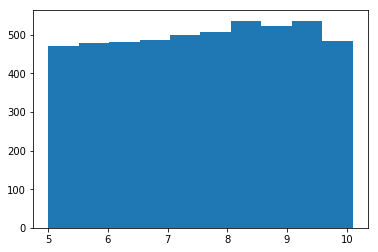

In [47]:
plt.hist(e_energy);

In [82]:
min(e_energy), max(e_energy)

(2.010660713279793, 5.176366354415428)

In [55]:
recon_energy = read_data(filename,
                            "EcalReconstructed", ["fRecoE"],
                            treename="cbmsim;2")

In [61]:
recon_energy = np.array([np.sum(val[0]) for val in recon_energy])

In [57]:
from collections import Counter

In [58]:
reco_len = Counter()
for val in recon_energy:
    assert len(val) ==1
    reco_len.update([len(val[0])])
    #assert len(val[0]) == 1

In [59]:
reco_len

Counter({1: 4790, 2: 206, 3: 4})